<a href="https://colab.research.google.com/github/frankZawacki/GColabProj/blob/main/Copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Transfer Learning and Pretrained Models with CIFAR-10 and Cats vs Dogs

This script:
1. Trains a baseline CNN on CIFAR-10, checkpointing the best model.
2. Reuses the convolutional base of that saved CIFAR-10 model to train on a subset of Cats vs Dogs via:
   a. Feature extraction (precompute conv features, then train classifier).
   b. Adding dense layers on top with the base frozen.
3. Uses a pretrained VGG16 (ImageNet) on CIFAR-10 with extended data augmentation, checkpointing & evaluation.

All datasets use the tf.data pipeline. Plots training/validation loss & accuracy.
"""

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import numpy as np

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


# ----------------------------
# Utility functions
# ----------------------------
def preprocess_image(image, label, image_size=(32, 32)):
    """Scale and resize image to desired size."""
    image = tf.image.convert_image_dtype(image, tf.float32)  # maps to [0,1]
    image = tf.image.resize(image, image_size)
    return image, label


def prepare_dataset(ds, batch_size=64, shuffle=False, image_size=(32, 32), augment_fn=None):
    """Apply preprocessing, optional augmentation, batching, and performance optimizations."""
    ds = ds.map(lambda x, y: preprocess_image(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
    if augment_fn is not None:
        ds = ds.map(lambda x, y: (augment_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


def plot_history(history, title_prefix=''):
    """Plot loss and accuracy curves from a Keras History object."""
    acc = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
    val_acc = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='train acc')
    plt.plot(epochs, val_acc, label='val acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()




In [2]:
# ----------------------------
# 1. Baseline CIFAR-10 Model
# ----------------------------
def build_cifar_baseline(include_top=True, input_shape=(32, 32, 3)):
    """
    Builds a CNN model for CIFAR-10.
    If include_top=False, returns the convolutional base ending in flattened features.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)
    x = layers.Dropout(0.25, name='drop1')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4')(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)
    x = layers.Dropout(0.25, name='drop2')(x)

    x = layers.Flatten(name='flatten')(x)
    if include_top:
        x = layers.Dense(512, activation='relu', name='dense1')(x)
        x = layers.Dropout(0.5, name='drop3')(x)
        outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
    else:
        outputs = x  # flattened feature vector
    model = models.Model(inputs, outputs, name='cifar_baseline' + ('_top' if include_top else '_base'))
    return model


def train_baseline_cifar():
    """Train baseline CIFAR-10 model, save best version, evaluate on test split."""
    # Load CIFAR-10 splits: 80% train, 10% val, 10% test
    cifar_splits = tfds.load('cifar10', as_supervised=True, split=[
        'train[:80%]', 'train[80%:90%]', 'train[90%:]'
    ], with_info=False)
    train_cifar, val_cifar, test_cifar = cifar_splits

    batch_size = 128
    train_ds = prepare_dataset(train_cifar, batch_size=batch_size, shuffle=True, image_size=(32, 32))
    val_ds = prepare_dataset(val_cifar, batch_size=batch_size, shuffle=False, image_size=(32, 32))
    test_ds = prepare_dataset(test_cifar, batch_size=batch_size, shuffle=False, image_size=(32, 32))

    # Build and compile model
    baseline_model = build_cifar_baseline(include_top=True, input_shape=(32, 32, 3))
    baseline_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])
    baseline_model.summary()

    # Checkpointing best model (by val accuracy)
    checkpoint_dir = 'checkpoints_cifar_baseline'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, 'best_model.h5')
    checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                                              monitor='val_accuracy', mode='max', verbose=1)

    history = baseline_model.fit(train_ds,
                                 validation_data=val_ds,
                                 epochs=15,
                                 callbacks=[checkpoint_cb],
                                 verbose=1)

    # Plot training curves
    plot_history(history, title_prefix='Baseline CIFAR-10')

    # Load best and evaluate
    best_model = tf.keras.models.load_model(checkpoint_path)
    test_loss, test_acc = best_model.evaluate(test_ds, verbose=2)
    print(f'Baseline CIFAR-10 test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}')
    return best_model  # return for reuse




In [3]:
# ----------------------------
# 2. Transfer to Cats vs Dogs using saved CIFAR conv base
# ----------------------------
def transfer_to_cats_vs_dogs(conv_base_model):
    """
    Given a trained CIFAR-10 convolutional base (without top), apply two transfer strategies to Cats vs Dogs:
    1. Feature extraction: precompute conv features and train a small classifier.
    2. Frozen base with new dense layers stacked and train end-to-end on classifier head.
    """
    # Load cats_vs_dogs dataset
    cats_dogs = tfds.load('cats_vs_dogs', as_supervised=True, with_info=False)
    full_cd = cats_dogs['train']  # no explicit split; use 'train'

    # Preprocess: resize to match conv_base input size (32x32) and scale
    def preprocess_cd(image, label):
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, (32, 32))
        return image, label

    # Take a balanced subset (simplification): just shuffle and take 3000 examples
    subset_cd = full_cd.map(preprocess_cd, num_parallel_calls=tf.data.AUTOTUNE)
    subset_cd = subset_cd.shuffle(5000, seed=42).take(3000)

    # Split 80/10/10
    total = 3000
    train_count = int(0.8 * total)
    val_count = int(0.1 * total)
    test_count = total - train_count - val_count

    train_cd = subset_cd.take(train_count)
    rest = subset_cd.skip(train_count)
    val_cd = rest.take(val_count)
    test_cd = rest.skip(val_count)

    batch_size = 64
    train_cd_ds = train_cd.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_cd_ds = val_cd.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_cd_ds = test_cd.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Ensure conv base is not trainable for feature extraction approach
    conv_base_model.trainable = False

    # Approach 1: Feature extraction (precompute)
    def extract_features(dataset, base_model):
        features = []
        labels = []
        for batch_images, batch_labels in dataset:
            feats = base_model(batch_images, training=False)  # flattened features
            features.append(feats.numpy())
            labels.append(batch_labels.numpy())
        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)
        return features, labels

    print("=== Feature Extraction Approach ===")
    train_features, train_labels = extract_features(train_cd_ds, conv_base_model)
    val_features, val_labels = extract_features(val_cd_ds, conv_base_model)
    test_features, test_labels = extract_features(test_cd_ds, conv_base_model)

    # Classifier on top of extracted features
    feature_input = layers.Input(shape=train_features.shape[1:])
    x = layers.Dense(256, activation='relu')(feature_input)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    feature_model = models.Model(feature_input, output, name='catsdogs_feature_extractor')

    feature_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Checkpoint
    os.makedirs('checkpoints_catsdogs_feature', exist_ok=True)
    feat_ckpt = callbacks.ModelCheckpoint('checkpoints_catsdogs_feature/best.h5',
                                          save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

    history_feat = feature_model.fit(train_features, train_labels,
                                     validation_data=(val_features, val_labels),
                                     epochs=15,
                                     callbacks=[feat_ckpt],
                                     verbose=1)

    plot_history(history_feat, title_prefix='Cats vs Dogs (Feature Extraction)')

    best_feat = tf.keras.models.load_model('checkpoints_catsdogs_feature/best.h5')
    test_loss_feat, test_acc_feat = best_feat.evaluate(test_features, test_labels, verbose=2)
    print(f'Feature extraction test loss: {test_loss_feat:.4f}, accuracy: {test_acc_feat:.4f}')

    # Approach 2: Frozen base with dense layers on top (end-to-end)
    print("\n=== Frozen Base + New Top Layers Approach ===")
    # Rebuild a model that takes image input, passes through frozen conv base, then new head
    conv_base_model.trainable = False  # ensure frozen
    inputs = layers.Input(shape=(32, 32, 3))
    x = conv_base_model(inputs, training=False)  # flattened features
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    frozen_model = models.Model(inputs, outputs, name='catsdogs_frozen_base')

    frozen_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    os.makedirs('checkpoints_catsdogs_frozen', exist_ok=True)
    frozen_ckpt = callbacks.ModelCheckpoint('checkpoints_catsdogs_frozen/best.h5',
                                            save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

    history_frozen = frozen_model.fit(train_cd_ds,
                                      validation_data=val_cd_ds,
                                      epochs=15,
                                      callbacks=[frozen_ckpt],
                                      verbose=1)

    plot_history(history_frozen, title_prefix='Cats vs Dogs (Frozen Base)')

    best_frozen = tf.keras.models.load_model('checkpoints_catsdogs_frozen/best.h5')
    test_loss_frozen, test_acc_frozen = best_frozen.evaluate(test_cd_ds, verbose=2)
    print(f'Frozen base test loss: {test_loss_frozen:.4f}, accuracy: {test_acc_frozen:.4f}')




In [4]:
# ----------------------------
# 3. Pretrained VGG16 on CIFAR-10 with augmentation
# ----------------------------
def pretrained_vgg16_cifar10():
    """Use VGG16 convolutional base with data augmentation on CIFAR-10."""
    # Data augmentation including extras (zoom and contrast)
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.15),
        layers.RandomContrast(0.15),
    ])

    def preprocess_for_vgg(image, label):
        # Resize to 224x224 and apply VGG preprocessing
        image = tf.image.resize(image, (224, 224))
        image = tf.image.convert_image_dtype(image, tf.float32)
        from tensorflow.keras.applications.vgg16 import preprocess_input
        image = preprocess_input(image * 255.0)  # VGG expects centered input
        return image, label

    # Load CIFAR-10 same splits
    cifar_splits = tfds.load('cifar10', as_supervised=True, split=[
        'train[:80%]', 'train[80%:90%]', 'train[90%:]'
    ], with_info=False)
    train_cifar, val_cifar, test_cifar = cifar_splits

    batch_size = 64
    # Apply data augmentation within the dataset pipeline for the training set
    train_vgg_ds = train_cifar.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
    train_vgg_ds = train_vgg_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                                    num_parallel_calls=tf.data.AUTOTUNE)
    train_vgg_ds = train_vgg_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_vgg_ds = val_cifar.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
    val_vgg_ds = val_vgg_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_vgg_ds = test_cifar.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
    test_vgg_ds = test_vgg_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Build model using VGG16 base
    from tensorflow.keras.applications import VGG16
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base.trainable = False  # freeze base

    inputs = layers.Input(shape=(224, 224, 3))
    # Remove data_augmentation layer from the model definition
    x = vgg_base(inputs, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes
    vgg_model = models.Model(inputs, outputs, name='vgg16_cifar10')

    vgg_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    vgg_model.summary()

    # Checkpoint
    os.makedirs('checkpoints_vgg16', exist_ok=True)
    vgg_ckpt = callbacks.ModelCheckpoint('checkpoints_vgg16/best.h5',
                                         save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

    # Train
    history_vgg = vgg_model.fit(train_vgg_ds,
                               validation_data=val_vgg_ds,
                               epochs=15,
                               callbacks=[vgg_ckpt],
                               verbose=1)

    plot_history(history_vgg, title_prefix='VGG16 CIFAR-10 Transfer')

    # Evaluate best model
    best_vgg = tf.keras.models.load_model('checkpoints_vgg16/best.h5')
    test_loss_vgg, test_acc_vgg = best_vgg.evaluate(test_vgg_ds, verbose=2)
    print(f'VGG16 CIFAR-10 test loss: {test_loss_vgg:.4f}, test accuracy: {test_acc_vgg:.4f}')

===== Baseline CIFAR-10 Training =====


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.YV8LZV_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.YV8LZV_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Model: "cifar_baseline_top"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,168,362 (8.27 MB)

 Trainable params: 2,168,362 (8.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2898 - loss: 1.9172
Epoch 1: val_accuracy improved from -inf to 0.53480, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.2901 - loss: 1.9164 - val_accuracy: 0.5348 - val_loss: 1.2916
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5332 - loss: 1.2996
Epoch 2: val_accuracy improved from 0.53480 to 0.64180, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5333 - loss: 1.2994 - val_accuracy: 0.6418 - val_loss: 1.0012
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6183 - loss: 1.0802
Epoch 3: val_accuracy improved from 0.64180 to 0.67760, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6183 - loss: 1.0800 - val_accuracy: 0.6776 - val_loss: 0.9066
Epoch 4/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6675 - loss: 0.9479
Epoch 4: val_accuracy improved from 0.67760 to 0.70600, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6676 - loss: 0.9478 - val_accuracy: 0.7060 - val_loss: 0.8424
Epoch 5/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6983 - loss: 0.8600
Epoch 5: val_accuracy improved from 0.70600 to 0.73680, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6984 - loss: 0.8598 - val_accuracy: 0.7368 - val_loss: 0.7465
Epoch 6/15
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7207 - loss: 0.7879
Epoch 6: val_accuracy did not improve from 0.73680
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7208 - loss: 0.7877 - val_accuracy: 0.7332 - val_loss: 0.7473
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7467 - loss: 0.7216
Epoch 7: val_accuracy improved from 0.73680 to 0.75540, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7467 - loss: 0.7215 - val_accuracy: 0.7554 - val_loss: 0.7047
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7658 - loss: 0.6714
Epoch 8: val_accuracy improved from 0.75540 to 0.75720, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7658 - loss: 0.6714 - val_accuracy: 0.7572 - val_loss: 0.6852
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7830 - loss: 0.6228
Epoch 9: val_accuracy did not improve from 0.75720
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7830 - loss: 0.6228 - val_accuracy: 0.7566 - val_loss: 0.7073
Epoch 10/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7946 - loss: 0.5820
Epoch 10: val_accuracy improved from 0.75720 to 0.76720, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7946 - loss: 0.5819 - val_accuracy: 0.7672 - val_loss: 0.6800
Epoch 11/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8080 - loss: 0.5404
Epoch 11: val_accuracy improved from 0.76720 to 0.77580, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8081 - loss: 0.5403 - val_accuracy: 0.7758 - val_loss: 0.6516
Epoch 12/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8219 - loss: 0.5003
Epoch 12: val_accuracy improved from 0.77580 to 0.77860, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8219 - loss: 0.5003 - val_accuracy: 0.7786 - val_loss: 0.6562
Epoch 13/15
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8318 - loss: 0.4725
Epoch 13: val_accuracy did not improve from 0.77860
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8319 - loss: 0.4725 - val_accuracy: 0.7768 - val_loss: 0.6829
Epoch 14/15
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8372 - loss: 0.4552
Epoch 14: val_accuracy did not improve from 0.77860
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8372 - loss: 0.4552 - val_accuracy: 0.7752 - val_loss: 0.6789
Epoch 15/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8458 - loss: 0.4380
Epoch 15: val_accuracy improved from 0.77860 to 0.78060, saving model to checkpoints_cifar_baseline/best_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8458 - loss: 0.4379 - val_accuracy: 0.7806 - val_loss: 0.6894


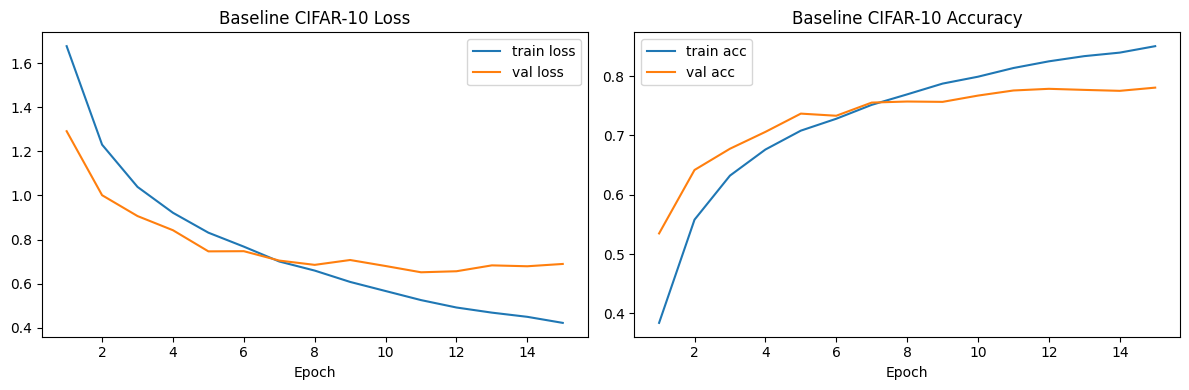

40/40 - 1s - 25ms/step - accuracy: 0.7822 - loss: 0.6780


Baseline CIFAR-10 test loss: 0.6780, test accuracy: 0.7822

===== Transfer to Cats vs Dogs =====


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.WNTHPT_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
=== Feature Extraction Approach ===
Epoch 1/15
54/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6592 - loss: 0.6295
Epoch 1: val_accuracy improved from -inf to 0.79333, saving model to checkpoints_catsdogs_feature/best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6741 - loss: 0.6109 - val_accuracy: 0.7933 - val_loss: 0.4633
Epoch 2/15
50/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8458 - loss: 0.3750
Epoch 2: val_accuracy improved from 0.79333 to 0.81667, saving model to checkpoints_catsdogs_feature/best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8454 - loss: 0.3764 - val_accuracy: 0.8167 - val_loss: 0.4116
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8887 - loss: 0.2909
Epoch 3: val_accuracy improved from 0.81667 to 0.82667, saving model to checkpoints_catsdogs_feature/best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8887 - loss: 0.2908 - val_accuracy: 0.8267 - val_loss: 0.4128
Epoch 4/15
51/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9274 - loss: 0.2118
Epoch 4: val_accuracy improved from 0.82667 to 0.83333, saving model to checkpoints_catsdogs_feature/best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9287 - loss: 0.2092 - val_accuracy: 0.8333 - val_loss: 0.3827
Epoch 5/15
51/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9682 - loss: 0.1366
Epoch 5: val_accuracy did not improve from 0.83333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9671 - loss: 0.1349 - val_accuracy: 0.8300 - val_loss: 0.4207
Epoch 6/15
52/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.1017
Epoch 6: val_accuracy did not improve from 0.83333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9758 - loss: 0.0985 - val_accuracy: 0.8333 - val_loss: 0.4966
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0778
Epoch 7: val_accuracy did not improve from 0.83333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0777 - val_accuracy: 0.8133 - val_loss: 0.5472
Epoch 8/15
51/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0570
Epoch 8: val_accuracy did not improve from 0.83333


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.0603 - val_accuracy: 0.8433 - val_loss: 0.4747
Epoch 10/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0590
Epoch 10: val_accuracy did not improve from 0.84333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9826 - loss: 0.0589 - val_accuracy: 0.8433 - val_loss: 0.5018
Epoch 11/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0518
Epoch 11: val_accuracy did not improve from 0.84333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0517 - val_accuracy: 0.8333 - val_loss: 0.4878
Epoch 12/15
51/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0269
Epoch 12: val_accuracy did not improve from 0.84333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0266 - val_accuracy: 0.8333 - val_loss: 0.5787
Epoch 13/15
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0278
Epoch 13: val_accuracy improved from 0.84333

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0272 - val_accuracy: 0.8533 - val_loss: 0.5336
Epoch 14/15
71/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0190
Epoch 14: val_accuracy did not improve from 0.85333
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0189 - val_accuracy: 0.8500 - val_loss: 0.5479
Epoch 15/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0105
Epoch 15: val_accuracy improved from 0.85333 to 0.86000, saving model to checkpoints_catsdogs_feature/best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0105 - val_accuracy: 0.8600 - val_loss: 0.5508


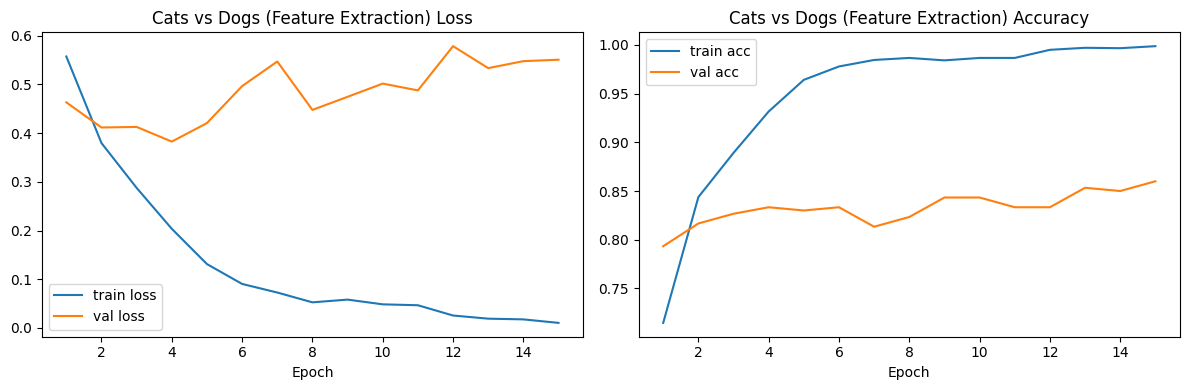

10/10 - 0s - 48ms/step - accuracy: 0.8400 - loss: 0.6963
Feature extraction test loss: 0.6963, accuracy: 0.8400

=== Frozen Base + New Top Layers Approach ===
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6234 - loss: 0.6364
Epoch 1: val_accuracy improved from -inf to 0.80333, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.6250 - loss: 0.6351 - val_accuracy: 0.8033 - val_loss: 0.4423
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7640 - loss: 0.4903
Epoch 2: val_accuracy improved from 0.80333 to 0.83000, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7637 - loss: 0.4906 - val_accuracy: 0.8300 - val_loss: 0.4057
Epoch 3/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8054 - loss: 0.4509
Epoch 3: val_accuracy did not improve from 0.83000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8044 - loss: 0.4516 - val_accuracy: 0.8300 - val_loss: 0.3990
Epoch 4/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7875 - loss: 0.4393
Epoch 4: val_accuracy improved from 0.83000 to 0.84333, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7875 - loss: 0.4396 - val_accuracy: 0.8433 - val_loss: 0.3469
Epoch 5/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8122 - loss: 0.4288
Epoch 5: val_accuracy did not improve from 0.84333
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.8123 - loss: 0.4288 - val_accuracy: 0.8133 - val_loss: 0.4081
Epoch 6/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7885 - loss: 0.4466
Epoch 6: val_accuracy improved from 0.84333 to 0.87667, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7887 - loss: 0.4460 - val_accuracy: 0.8767 - val_loss: 0.3242
Epoch 7/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8168 - loss: 0.3940
Epoch 7: val_accuracy improved from 0.87667 to 0.88333, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8169 - loss: 0.3938 - val_accuracy: 0.8833 - val_loss: 0.3247
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8285 - loss: 0.3855
Epoch 8: val_accuracy did not improve from 0.88333
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8285 - loss: 0.3855 - val_accuracy: 0.8367 - val_loss: 0.3533
Epoch 9/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8529 - loss: 0.3593
Epoch 9: val_accuracy did not improve from 0.88333
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.8526 - loss: 0.3596 - val_accuracy: 0.8733 - val_loss: 0.3259
Epoch 10/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8478 - loss: 0.3523
Epoch 10: val_accuracy improved from 0.88333 to 0.89000, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8477 - loss: 0.3521 - val_accuracy: 0.8900 - val_loss: 0.3087
Epoch 11/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8545 - loss: 0.3291
Epoch 11: val_accuracy did not improve from 0.89000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8547 - loss: 0.3294 - val_accuracy: 0.8767 - val_loss: 0.3263
Epoch 12/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8530 - loss: 0.3255
Epoch 12: val_accuracy did not improve from 0.89000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8529 - loss: 0.3256 - val_accuracy: 0.8733 - val_loss: 0.3059
Epoch 13/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8661 - loss: 0.3170
Epoch 13: val_accuracy improved from 0.89000 to 0.89333, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8656 - loss: 0.3179 - val_accuracy: 0.8933 - val_loss: 0.2742
Epoch 14/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8853 - loss: 0.2910
Epoch 14: val_accuracy improved from 0.89333 to 0.92333, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8852 - loss: 0.2911 - val_accuracy: 0.9233 - val_loss: 0.2167
Epoch 15/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8661 - loss: 0.3001
Epoch 15: val_accuracy improved from 0.92333 to 0.92667, saving model to checkpoints_catsdogs_frozen/best.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8661 - loss: 0.3003 - val_accuracy: 0.9267 - val_loss: 0.2397


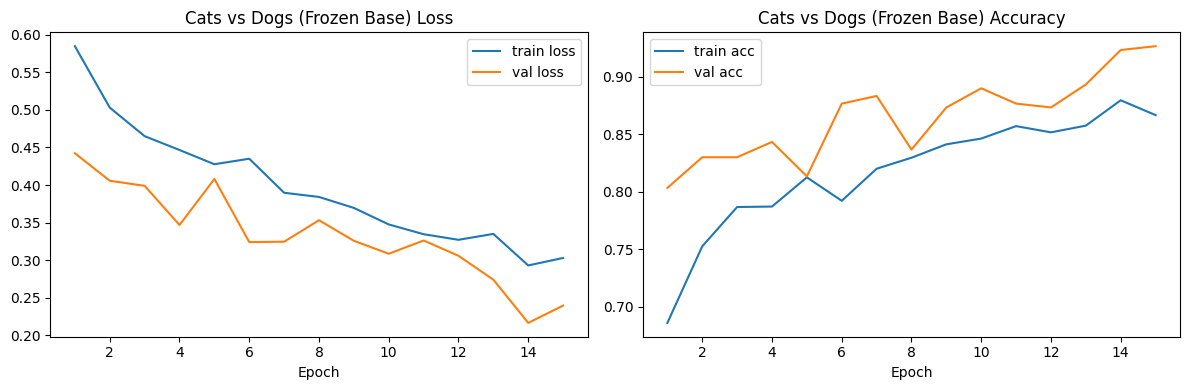

5/5 - 3s - 608ms/step - accuracy: 0.9067 - loss: 0.2869
Frozen base test loss: 0.2869, accuracy: 0.9067

===== Pretrained VGG16 on CIFAR-10 with Augmentation =====
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.1092 - loss: 3.8596
Epoch 1: val_accuracy improved from -inf to 0.09060, saving model to checkpoints_vgg16/best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 311s 422ms/step - accuracy: 0.1091 - loss: 3.8577 - val_accuracy: 0.0906 - val_loss: 5.9388
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.1073 - loss: 2.3109
Epoch 2: val_accuracy improved from 0.09060 to 0.12240, saving model to checkpoints_vgg16/best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 287s 416ms/step - accuracy: 0.1073 - loss: 2.3109 - val_accuracy: 0.1224 - val_loss: 74.3035
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1010 - loss: 2.3088
Epoch 3: val_accuracy improved from 0.12240 to 0.13980, saving model to checkpoints_vgg16/best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 289s 419ms/step - accuracy: 0.1010 - loss: 2.3088 - val_accuracy: 0.1398 - val_loss: 60.9741
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1136 - loss: 2.2951
Epoch 4: val_accuracy improved from 0.13980 to 0.14300, saving model to checkpoints_vgg16/best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 288s 419ms/step - accuracy: 0.1136 - loss: 2.2951 - val_accuracy: 0.1430 - val_loss: 207.8668
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.1160 - loss: 2.2797
Epoch 5: val_accuracy improved from 0.14300 to 0.15060, saving model to checkpoints_vgg16/best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 421ms/step - accuracy: 0.1160 - loss: 2.2797 - val_accuracy: 0.1506 - val_loss: 149.6892
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.1173 - loss: 2.2826
Epoch 6: val_accuracy improved from 0.15060 to 0.17640, saving model to checkpoints_vgg16/best.h5


625/625 ━━━━━━━━━━━━━━━━━━━━ 287s 417ms/step - accuracy: 0.1173 - loss: 2.2826 - val_accuracy: 0.1764 - val_loss: 33.9908
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.1146 - loss: 2.2750
Epoch 7: val_accuracy did not improve from 0.17640
625/625 ━━━━━━━━━━━━━━━━━━━━ 290s 421ms/step - accuracy: 0.1146 - loss: 2.2750 - val_accuracy: 0.1702 - val_loss: 17.9011
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1209 - loss: 2.2752
Epoch 8: val_accuracy did not improve from 0.17640
625/625 ━━━━━━━━━━━━━━━━━━━━ 288s 418ms/step - accuracy: 0.1209 - loss: 2.2752 - val_accuracy: 0.1642 - val_loss: 15.8258
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.1182 - loss: 2.2782
Epoch 9: val_accuracy did not improve from 0.17640
625/625 ━━━━━━━━━━━━━━━━━━━━ 291s 421ms/step - accuracy: 0.1182 - loss: 2.2782 - val_accuracy: 0.1400 - val_loss: 542.6030
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1180 - loss: 2.2761
Epoch

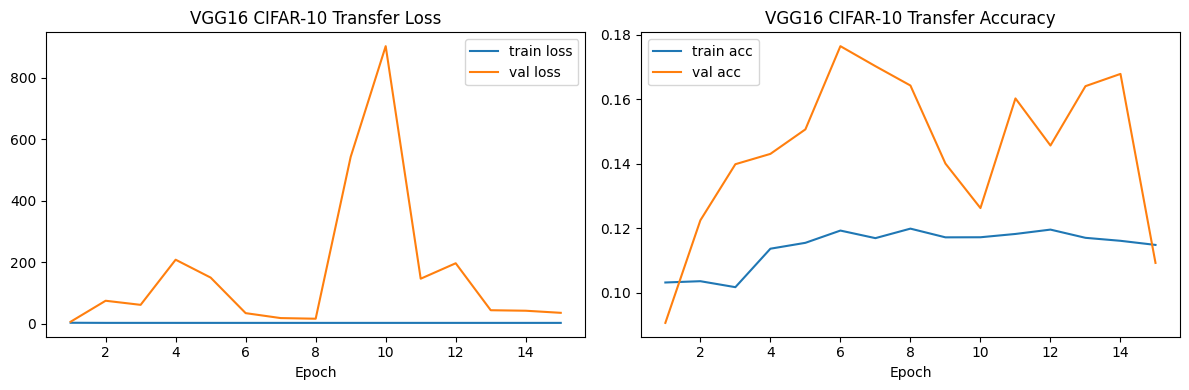

79/79 - 26s - 325ms/step - accuracy: 0.1800 - loss: 30.4886
VGG16 CIFAR-10 test loss: 30.4886, test accuracy: 0.1800


In [5]:
# ----------------------------
# Main execution
# ----------------------------
if __name__ == '__main__':
    # 1. Train baseline CIFAR-10 model and get conv base
    print("===== Baseline CIFAR-10 Training =====")
    full_cifar_model = train_baseline_cifar()

    # Extract convolutional base (without top) with weights from trained model
    # Build a conv base model and copy weights from full model (matching names)
    conv_base = build_cifar_baseline(include_top=False, input_shape=(32, 32, 3))
    # Load full model weights (best) to a temp model to ensure consistency
    best_full = tf.keras.models.load_model('checkpoints_cifar_baseline/best_model.h5')
    # Transfer conv layer weights by matching layer names
    for layer in conv_base.layers:
        try:
            source_layer = best_full.get_layer(name=layer.name)
            layer.set_weights(source_layer.get_weights())
        except ValueError:
            # no matching layer (e.g., InputLayer or layers only in base)
            continue

    # 2. Transfer learning to Cats vs Dogs using saved conv base
    print("\n===== Transfer to Cats vs Dogs =====")
    transfer_to_cats_vs_dogs(conv_base)

    # 3. Pretrained VGG16 on CIFAR-10 with augmentation
    print("\n===== Pretrained VGG16 on CIFAR-10 with Augmentation =====")
    pretrained_vgg16_cifar10()
